## Data Preprocessing
* Loading the train and test dataset from hugging face
* Ignored the unsupervised dataset
* Cleaning it using `re` and creating a vocabulary
* Used `GloVe 100d` to convert words into their corresponding 100-dim word embeddings


In [3]:
# Importing dataset from hugging face
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])
unlabelled_df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["unsupervised"])


/home/adishesh/ml_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")


In [6]:
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()
unsup_df = ds["unsupervised"].to_pandas()

In [7]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)           # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)         # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra spaces
    text = re.sub(r"[-–—]", " ", text)  # replace hyphens/dashes with space

    return text


train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)

In [8]:
import numpy as np
def load_glove(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                continue
    return embeddings_index

# Usage
embeddings_index = load_glove("glove.6B.100d.txt")
vector = embeddings_index["movie"]
print(vector.shape)  # (100,)



(100,)


In [9]:
from collections import Counter 


# Build vocabulary and a simple word to index python dict
# PAD used to convert all words to same legnth
# UNK used for uncles(jk for unknown words)
def build_vocab(texts, min_freq = 2):
    counter = Counter()
    for text in texts: 
        counter.update(text.split())

    vocab = ["<PAD>", "<UNK>"] + [word for word, freq in counter.items() if freq >= min_freq]


    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return vocab, word2idx

all_texts = train_df["text"].tolist() + test_df["text"].tolist()
vocab, word2idx = build_vocab(all_texts)
print(vocab[:10])

['<PAD>', '<UNK>', 'i', 'rented', 'am', 'curiousyellow', 'from', 'my', 'video', 'store']


In [10]:
import torch
import numpy as np

embedding_dim = 100
vocab_size = len(word2idx)
embedding_matrix = torch.randn(vocab_size, embedding_dim)

# Set the <PAD> token vector to zeros
embedding_matrix[word2idx["<PAD>"]] = torch.zeros(embedding_dim)

# Fill known GloVe vectors
for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = torch.tensor(embeddings_index[word], dtype=torch.float32)



In [12]:
# Create idx2word mapping
idx2word = {idx: word for word, idx in word2idx.items()}

In [81]:
# Save word2idx and idx2word as .pt files
torch.save(word2idx, "word2idx.pt")
torch.save(idx2word, "idx2word.pt")
# Save the embedding matrix
torch.save(embedding_matrix, "embedding_matrix.pt")
        

In [11]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=word2idx["<PAD>"])
    labels = torch.tensor(labels)
    return texts_padded, labels

# Pytorch Dataset
* Concatenates the training and test dataset and performs a 70:10:20 train:val:test split
* Defines a custom Pytorch Dataset to iterate over the dataset while training with `DataLoader`


In [13]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



# Pytorch Dataset to load the data
class SentimentDataset(Dataset):
    def __init__(self, data, word2idx):
        self.texts = data["text"].values
        self.labels = data["label"].values 
        self.word2idx = word2idx

    def encode(self, text):
        return [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in text.split()]

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.encode(self.texts[idx])
        label = self.labels[idx]
        return torch.tensor(tokens, dtype = torch.long), torch.tensor(label, dtype = torch.long)
    


from sklearn.model_selection import train_test_split

# Combine train and test dataframes
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Ensure equal number of 0 and 1 labels in each split
def stratified_split(df, train_size=0.7, val_size=0.1, test_size=0.2, label_col="label", random_state=42):
    # First, split into train and temp (val+test)
    train_df, temp_df = train_test_split(
        df, 
        train_size=train_size, 
        stratify=df[label_col], 
        random_state=random_state
    )
    # Calculate val proportion of temp
    val_prop = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df, 
        train_size=val_prop, 
        stratify=temp_df[label_col], 
        random_state=random_state
    )
    return train_df, val_df, test_df

train_split, val_split, test_split = stratified_split(full_df, train_size=0.7, val_size=0.1, test_size=0.2)

# Create dataset objects
train_dataset = SentimentDataset(train_split, word2idx)
val_dataset = SentimentDataset(val_split, word2idx)
test_dataset = SentimentDataset(test_split, word2idx)

# Create data loaders (you need to have collate_fn defined beforehand)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=4)

In [60]:
train_dataset.__getitem__(0)

(tensor([79705,    40,  2521,     1, 79705,    40,  1736,   153,     1,    11,
         60529,   153,    51,    76,     7,   485,   468,    11,    12,  6922,
            45,   594,    13,  1736, 43675,    13,  4190, 13033,    11,    13,
         22749,    74,    11,   176,  8871,    66,  4240,     1, 11317,     6,
             1,    13, 79560, 11317,   558,   778,     1,   157,     1, 36468,
           526, 16997,     6,  2900,     1,   594,    13,  2836,    26, 68049,
             1,  1833,  3155, 74305,   333,   498,   634,    13,     1,  5497,
           249,   145,  1166,    48,     1,  2054,   176, 18263,  8075,     1,
          1534,    85,    40, 78262,  4620,    40,  2080,    11,  3152, 32976,
            22,  1612,     1,  2545,     1,   393,   203,  1282,     1,    92,
             1,   472, 10341,    65,  2904,    13,     1,  1282,  1290,   103,
            40, 11983,     1,    15,    60, 16581,   268, 19831,   868,     1,
         18151]),
 tensor(1))



### Training Loop Overview

This training loop performs supervised learning on a sentiment classification task using PyTorch. Key components of the loop:

* Tracks training and validation metrics
    - Training and Validation Accuracies
    - Training and Validation Losses
    - Precision F1 score, recall
    - Logs the meetrics in a text file `../logs/`


* Tracks and saves the best model state based on **validation accuracy**.
* Utilizes early stopping with a patience of 3 epochs
* After training, `plot_training_curves()` plots training and validation accuracy/loss over epochs and saves it to `../plots/`.



In [14]:


from sklearn.metrics import precision_score, recall_score, f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Parameters to keep track of the best model
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    best_val_loss = float('inf')
    epochs_no_improve = 0


    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(output, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if epoch == 0:
            with open(f"../logs/{model_name}.txt", "w") as log_file:
                log_file.write(f"Training started for model: {model}\n")

        # Direct print statements to "../logs/{model_name}.txt"
        with open(f"../logs/{model_name}.txt", "a") as log_file:
            log_file.write(f"Epoch [{epoch + 1}/{n_epochs}] | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%\n")
        

        # Validation 
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.to(device)

                output = model(texts)
                loss = criterion(output, labels)
                val_loss += loss.item()

                _, predicted = torch.max(output, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculating validation losses and accuracies
        val_accuracy = correct / total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Calculate and Print Metrics
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)


        

        # Direct print statements to "../logs/{model_name}.txt"
        with open(f"../logs/{model_name}.txt", "a") as log_file:
            log_file.write(f"\nEpoch [{epoch + 1}/{n_epochs}] | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.2f}%\n")
            log_file.write(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}\n")


        # Save best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_state_dict = model.state_dict()
            best_epoch = epoch + 1
            best_val_loss = val_loss
            epochs_no_improve = 0
            # torch.save(best_state_dict, f"../models/{model_name}.pth")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= 3:  # If no improvement for 3 epochs
                print(f"Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}.")
                break
    


    return train_losses, train_accuracies, val_losses, val_accuracies


import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, model, model_name):
    epochs = np.arange(1, len(train_accuracies) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, marker='o', color='blue', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker = 'o', color='orange', label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Test Accuracy")
    plt.grid(True)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Losses')
    plt.plot(epochs, val_losses, marker = "o", color = "orange", label = "Validation Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Test Losses")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../plots/{model_name}train_accs_vs_losses.png")
    plt.show()

print(device)


cuda




### Vanilla RNN Model


* **Embedding Layer**: Initialized with GloVe vectors (trainable).
* **RNN Layer**: Processes token sequences.
* **Dropout**: Dropout applied after the final hidden layer
* **Attention**: If enabled, computes a context vector using the final hidden state.
* **Output Layer**: Uses the last hidden state (or context + hidden state) for classification.



In [15]:
import torch.nn as nn

train_losses_v, train_accuracies_v, val_losses_v, val_accuracies_v = {}, {}, {}, {}


class VanillaRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, attention_class = None, attn_dim = None, dropout = 0.3):
        super().__init__()
        
        self.hidden_size = hidden_size 
        num_embeddings, embed_dim = embedding_matrix.shape 
        self.use_attention = attention_class is not None 
        self.dropout = dropout


        # Embed the tokens with GloVe pretrained embeddings, finetuning weights is possble
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # Instantiate an RNN with embed_dim and hidden size length time steps 
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        # Add a Dropout layer
        self.dropout_layer = nn.Dropout(self.dropout)
        
        # Instantiate the attention module 
        if self.use_attention:
            # Enc_dim and dec_dim are same
            self.attention = attention_class(hidden_size, hidden_size, attn_dim)
            # Final connected MLP
            self.fc = nn.Linear(hidden_size*2, output_size)

        else:
            self.fc = nn.Linear(hidden_size, output_size)
        
        

    def forward(self, x):
        x = self.embedding(x)
        # Initial Hidden State is 0
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        # Applyign dropout 
        out = self.dropout_layer(out)

        if self.use_attention:
            context, attn_weights = self.attention(out, hn[-1])
            context = context.squeeze(1)
            combined = torch.cat((context, hn[-1]), dim=1)
            output = self.fc(combined)
        else:
            output = self.fc(out[:, -1, :])
        return output
    
vocab_size = len(vocab) + 1
embed_size = 100
hidden_size = 100 
output_size = 2
rnn_model = VanillaRNN(embedding_matrix, hidden_size, output_size)


# Hyperparameters for training
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-2)
# n_epochs = 10

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rnn_model.to(device)
# criterion.to(device)

# Train the model and plot training curves
# model_name = "vanilla_rnn"
# train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name] = train_model(rnn_model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name)
# plot_training_curves(train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name], rnn_model, model_name)

In [ ]:
# # Checking if the model is not printing 0/1 for everything
# for texts, labels in train_loader:
#     texts = texts.to(device)
#     labels = labels.to(device)
#     output = rnn_model(texts)
#     _, predicted = torch.max(output, dim=1)
#     print(f"Predicted: {predicted[:10]}, Actual: {labels[:10]}")
#     break

Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), Actual: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')




### Vanilla LSTM 


* **Embedding Layer**: Initialized with GloVe embeddings (trainable).
* **LSTM Layer**: Processes input sequences with learned hidden and cell states.
* **Dropout**: Applied to LSTM outputs to prevent overfitting.
* **Attention (optional)**: If provided, uses the final hidden state to compute a context vector over the sequence.
* **Output Layer**:

  * With attention: Uses `[context; hidden]`.
  * Without attention: Uses only the final hidden state (`hn[-1]`).


In [41]:
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class VanillaLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, attention_class = None, attn_dim = None, dropout = 0.3):
        super().__init__()

        self.hidden_size = hidden_size
        # Applying pretrained embeddings to tokens
        num_embeddings, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, batch_first=True)
        # Dropout Layer
        self.dropout_layer = nn.Dropout(dropout)

        # Check if attention class is provided
        self.use_attention = attention_class is not None 
        if self.use_attention:
            # Instantiate Model
            self.attention = attention_class(self.hidden_size, self.hidden_size, attn_dim)
            
            # Final layer should be the concat of hn[-1] and the context vector
            self.fc = nn.Linear(self.hidden_size*2, output_size)
        else:
            self.fc = nn.Linear(self.hidden_size, output_size)




    def forward(self, x):
        x = self.embedding(x)
        x = x.to(device)
        # Set initial hidden state to 0
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)


        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout_layer(out)

        if self.use_attention:
            context, attn_weights = self.attention(out, hn[-1])
            context = context.squeeze(1)
            combined = torch.cat((context, hn[-1]), dim = 1)
            output = self.fc(combined)
            return output, attn_weights.squeeze(1)
        else:
            output = self.fc(hn[-1])
            return output


    
    
vocab_size = len(vocab) + 1
embed_size = 100
hidden_size = 100 
output_size = 2




# Instantiate the LSTM model
lstm_model = VanillaLSTM(embedding_matrix, hidden_size, output_size)
lstm_model.to(device)


# Hyperparameters for training
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)
# n_epochs = 10


# # Train model
# model_name = "vanilla_lstm"
# train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name] = train_model(lstm_model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name)
# plot_training_curves(train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name], lstm_model, model_name)


VanillaLSTM(
  (embedding): Embedding(83334, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
# # Checking if the model is not printing 0/1 for everything
# for texts, labels in train_loader:
#     texts = texts.to(device)
#     labels = labels.to(device)
#     output = lstm_model(texts)
#     _, predicted = torch.max(output, dim=1)
#     print(f"Predicted: {predicted[:10]}, Actual: {labels[:10]}")
#     break

Predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), Actual: tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')




### Bidirectional RNN


* **Embedding Layer**: Initialized with GloVe (trainable).
* **BiRNN Layer**: Processes sequences in both forward and backward directions, capturing richer context.
* **Hidden State**: Final hidden states from both directions are concatenated.
* **Attention (optional)**: Uses bidirectional output and final hidden state to compute a context vector.
* **Output Layer**:

  * With attention: Uses `[context; forward_hn; backward_hn]`
  * Without attention: Uses concatenated hidden state 

Returns logits for classification (no dropout used by default).


In [17]:
import torch.nn as nn


class BidirectionalRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, attention_class=None, attn_dim=None):
        super().__init__()


        num_embeddings, embed_size = embedding_matrix.shape
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = False)


        
            

        self.birnn = nn.RNN(embed_size, hidden_size, batch_first=True, bidirectional=True)

        # Check if attention class is provided
        self.use_attention = attention_class is not None 
        if self.use_attention:
            self.attention = attention_class(2*hidden_size, 2*hidden_size, attn_dim)
            # TO concat context vector with hn[-1]
            self.fc = nn.Linear(4*hidden_size, output_size)
        else:
            self.fc = nn.Linear(2*hidden_size, output_size)


    def forward(self, x):
        x = self.embedding(x)
        # Set initial hidden state to 0
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.birnn(x, h0)


        final_hidden = torch.cat((hn[0], hn[1]), dim = 1)

        if self.use_attention:
            context, attn_weights = self.attention(out, final_hidden)
            context = context.squeeze(1)
            combined = torch.cat((context, final_hidden), dim = 1)
            output = self.fc(combined)
        else:
            output = self.fc(final_hidden)
        return output
    
vocab_size = len(vocab) + 1
embed_size = 100
hidden_size = 100 
output_size = 2
birnn_model = BidirectionalRNN(embedding_matrix, hidden_size, output_size)
birnn_model.to(device)


# Hyperparameters for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(birnn_model.parameters(), lr = 1e-2)
n_epochs = 10


# Train Model and plot accuracies
# model_name = "bidirectional_rnn"
# train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name] = train_model(rnn_model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name)
# plot_training_curves(train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name], rnn_model, model_name)


In [21]:
# Checking if the model is not printing 0/1 for everything
for texts, labels in train_loader:
    texts = texts.to(device)
    labels = labels.to(device)
    output = birnn_model(texts)
    _, predicted = torch.max(output, dim=1)
    print(f"Predicted: {predicted[:10]}, Actual: {labels[:10]}")
    break

Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0'), Actual: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')




### Bidirectional LSTM

This model uses a bidirectional LSTM for sentiment classification:

* **Embedding Layer**: Initialized with GloVe vectors (trainable).
* **BiLSTM Layer**: Captures context in both forward and backward directions.
* **Dropout**: Applied to LSTM outputs to reduce overfitting.
* **Attention (optional)**: Computes a context vector from bidirectional outputs and hidden states.
* **Output Layer**:

  * With attention: Uses `[context; forward_hn; backward_hn]` to `4 × hidden_size`.
  * Without attention: Uses final hidden state to `2 × hidden_size`.




In [18]:
import torch
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, attention_class=None, attn_dim=None, dropout=0.3):
        super().__init__()
        
        self.hidden_size = hidden_size
        num_embeddings, embed_size = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.bilstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True, dropout = dropout, num_layers = 1)

        # Applying final dropout layer
        self.dropout_layer = nn.Dropout(dropout)

        self.use_attention = attention_class is not None
        if self.use_attention:
            self.attention = attention_class(2 * hidden_size, 2 * hidden_size, attn_dim)
            self.fc = nn.Linear(4 * hidden_size, output_size)
        else:
            self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)

        # Initial hidden and cell states (num_directions = 2)
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))  # out: (batch, seq_len, 2*hidden_size)
        out = self.dropout_layer(out)  # Apply dropout to the output of LSTM

        # Concatenate final forward and backward hidden states
        final_hidden = torch.cat((hn[0], hn[1]), dim=1)  # (batch, 2*hidden_size)

        if self.use_attention:
            context, attn_weights = self.attention(out, final_hidden)  # both: (batch, 2*hidden_size)
            context = context.squeeze(1)
            combined = torch.cat((context, final_hidden), dim=1)       # (batch, 4*hidden_size)
            output = self.fc(combined)
            return output, attn_weights.squeeze(1)
        else:
            output = self.fc(final_hidden)
            return output


    
vocab_size = len(vocab) + 1
embed_size = 100
hidden_size = 100 
output_size = 2
bilstm_model = BidirectionalLSTM(embedding_matrix, hidden_size, output_size)
bilstm_model.to(device)


# Hyperparameters for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr = 1e-2)
n_epochs = 10


# Train Model and plot accruacies
# model_name = "bidirectional_lstm"
# train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name] = train_model(rnn_model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name)
# plot_training_curves(train_losses_v[model_name], train_accuracies_v[model_name], val_losses_v[model_name], val_accuracies_v[model_name], rnn_model, model_name)

/home/adishesh/ml_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
# # Checking if the model is not printing 0/1 for everything
# for texts, labels in train_loader:
#     texts = texts.to(device)
#     labels = labels.to(device)
#     output = bilstm_model(texts)
#     _, predicted = torch.max(output, dim=1)
#     print(f"Predicted: {predicted[:10]}, Actual: {labels[:10]}")
#     break

Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), Actual: tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')


# Base Models Comparison
Trained all the four models without applying attention and same hyperparameters
* Hyperparameters Used
    - Criterion: Cross Entropy Loss
    - Optimizer: Adam optimizer with `lr = 1e-2`
    - Epochs: 10 with early stopping


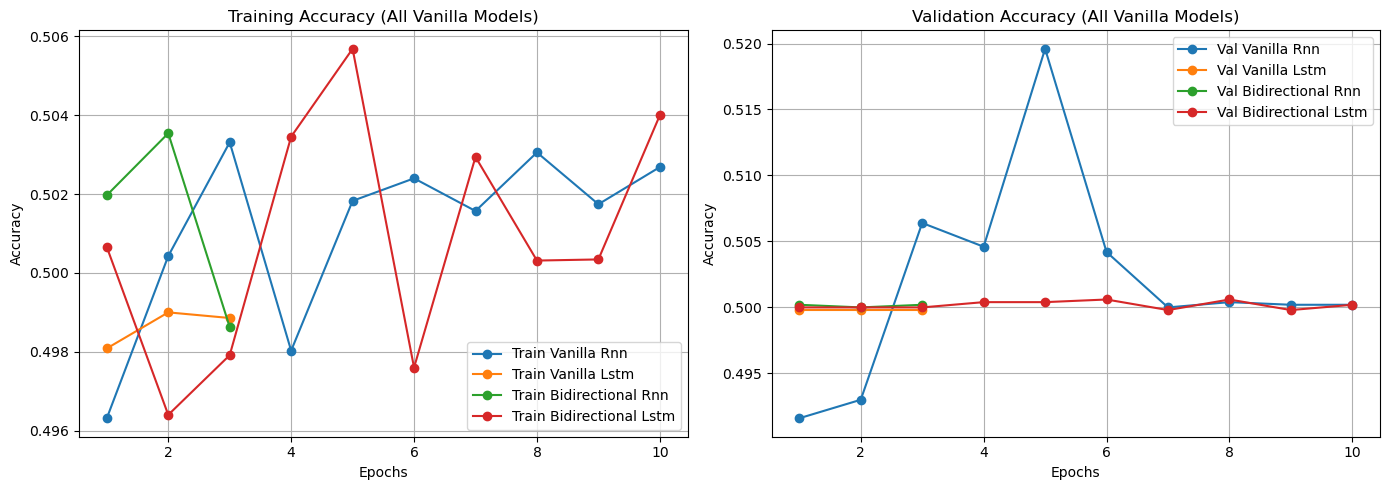

In [24]:
# Comparing all the vanilla models in a single plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
for model_name in train_accuracies_v.keys():
    plt.plot(
        np.arange(1, len(train_accuracies_v[model_name]) + 1),
        train_accuracies_v[model_name],
        marker='o',
        label=f'Train {model_name.replace("_", " ").title()}'
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy (All Vanilla Models)")
plt.grid(True)
plt.legend()

# Validation accuracy plot
plt.subplot(1, 2, 2)
for model_name in val_accuracies_v.keys():
    plt.plot(
        np.arange(1, len(val_accuracies_v[model_name]) + 1),
        val_accuracies_v[model_name],
        marker='o',
        label=f'Val {model_name.replace("_", " ").title()}'
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (All Vanilla Models)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("../plots/vanilla_models_accuracy_comparison.png")
plt.show()

In [25]:
print(train_df["label"].value_counts())

label
0    12500
1    12500
Name: count, dtype: int64


# Attention Models Comparison
Trained the base models along with all the 4 attention mechanisms, with same hyperparameters
* Hyperparameters Used:
    - Criterion: Cross Entropy Loss
    - Optimizer: Adam with `lr=1e-3` and `weight_decay = 1e-5`
    - Epochs: 10 with early stopping




In [33]:
# Imports to reflect changes in attention folder to jupyter notebook
import importlib
import attention.bahdanau as bahdanau
import attention.luongdot as luongdot
import attention.luongconcat as luongconcat
import attention.luonggeneral as luonggeneral

importlib.reload(bahdanau)
importlib.reload(luongdot)
importlib.reload(luongconcat)
importlib.reload(luonggeneral)

# Importing attention mechanisms
from attention.bahdanau import BahdanauAttention
from attention.luongdot import LuongDotAttention
from attention.luongconcat import LuongConcatAttention
from attention.luonggeneral import LuongGeneralAttention



epochs = np.arange(1, n_epochs + 1)

# Function to train one model with multiple attention classes
def train_model_attention(model_name, model_factory, train_loader, val_loader, criterion, optimizer, n_epochs):
    attention_classes = [
        ("Bahdanau", BahdanauAttention),
        ("LuongDot", LuongDotAttention),
        ("LuongConcat", LuongConcatAttention),
        ("LuongGeneral", LuongGeneralAttention),
    ]

    all_train_accuracies = {}
    all_val_accuracies = {}
    all_train_losses = {}
    all_val_losses = {}

    for name, attention_class in attention_classes:
        print(f"\nTraining {model_name} with {name} Attention\n")

        model = model_factory(attention_class).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)



        train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name = model_name + f"_{name}"
        )
        
        all_train_losses[name] = train_losses
        all_train_accuracies[name] = train_accuracies
        all_val_losses[name] = val_losses
        all_val_accuracies[name] = val_accuracies
    
    
 


    return all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses




# Vanilla RNN with Attention

In [ ]:
# Instantiating rnn_model class
def rnn_factory(attn_class):
    return VanillaRNN(
        embedding_matrix=embedding_matrix,
        hidden_size=64,
        output_size=2,
        attention_class=attn_class,
        attn_dim=32
    )



# Hyperparameters
criterion = nn.CrossEntropyLoss()
n_epochs = 10


rnn_train_accs, rnn_train_losses, rnn_val_accs, rnn_val_losses = train_model_attention(
    model_name = "vanilla_rnn_attention",
    model_factory=rnn_factory,
    train_loader = train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs
)


# Vanilla LSTM with attention

In [ ]:
# Instantiating rnn_model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def lstm_factory(attn_class):
    return VanillaLSTM(
        embedding_matrix=embedding_matrix,
        hidden_size=100,
        output_size=2,
        attention_class=attn_class,
        attn_dim=64
    ).to(device)



# Hyperparameters
criterion = nn.CrossEntropyLoss()
n_epochs = 10


lstm_train_accs, lstm_train_losses, lstm_val_accs, lstm_val_losses = train_model_attention(
    model_name = "Vanilla_lstm_attention",
    model_factory=lstm_factory,
    train_loader = train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs
)


# Bidirectional RNN with Attention

In [34]:
# Instantiating rnn_model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def birnn_factory(attn_class):
    return BidirectionalRNN(
        embedding_matrix=embedding_matrix,
        hidden_size=100,
        output_size=2,
        attention_class=attn_class,
        attn_dim=64
    ).to(device)



# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(birnn_model.parameters(), lr=1e-3, weight_decay=1e-5)
n_epochs = 10


birnn_train_accs, birnn_train_losses, birnn_val_accs, birnn_val_losses = train_model_attention(
    model_name = "bi-rnn_attention",
    model_factory=birnn_factory,
    train_loader = train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs
)



Training bi-rnn_attention with Bahdanau Attention

Early stopping triggered at epoch 4. Best validation accuracy: 90.92% at epoch 2.

Training bi-rnn_attention with LuongDot Attention

Early stopping triggered at epoch 7. Best validation accuracy: 86.76% at epoch 2.

Training bi-rnn_attention with LuongConcat Attention

Early stopping triggered at epoch 5. Best validation accuracy: 90.96% at epoch 3.

Training bi-rnn_attention with LuongGeneral Attention

Early stopping triggered at epoch 5. Best validation accuracy: 87.98% at epoch 3.


# Bidirectional LSTM with Attention

In [39]:
# Instantiating rnn_model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def bilstm_factory(attn_class):
    return BidirectionalLSTM(
        embedding_matrix=embedding_matrix,
        hidden_size=64,
        output_size=2,
        attention_class=attn_class,
        attn_dim=32
    ).to(device)



# Hyperparameters
criterion = nn.CrossEntropyLoss()
n_epochs = 10


bilstm_train_accs, bilstm_train_losses, bilstm_val_accs, bilstm_val_losses = train_model_attention(
    model_name = "bi-lstm_attention",
    model_factory=bilstm_factory,
    train_loader = train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs
)



Training bi-lstm_attention with Bahdanau Attention



/home/adishesh/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Early stopping triggered at epoch 5. Best validation accuracy: 91.10% at epoch 3.

Training bi-lstm_attention with LuongDot Attention



/home/adishesh/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Early stopping triggered at epoch 5. Best validation accuracy: 90.94% at epoch 3.

Training bi-lstm_attention with LuongConcat Attention



/home/adishesh/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Early stopping triggered at epoch 6. Best validation accuracy: 90.98% at epoch 4.

Training bi-lstm_attention with LuongGeneral Attention



/home/adishesh/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Early stopping triggered at epoch 6. Best validation accuracy: 90.92% at epoch 4.


# Comparing Baseline Models with All Attentions



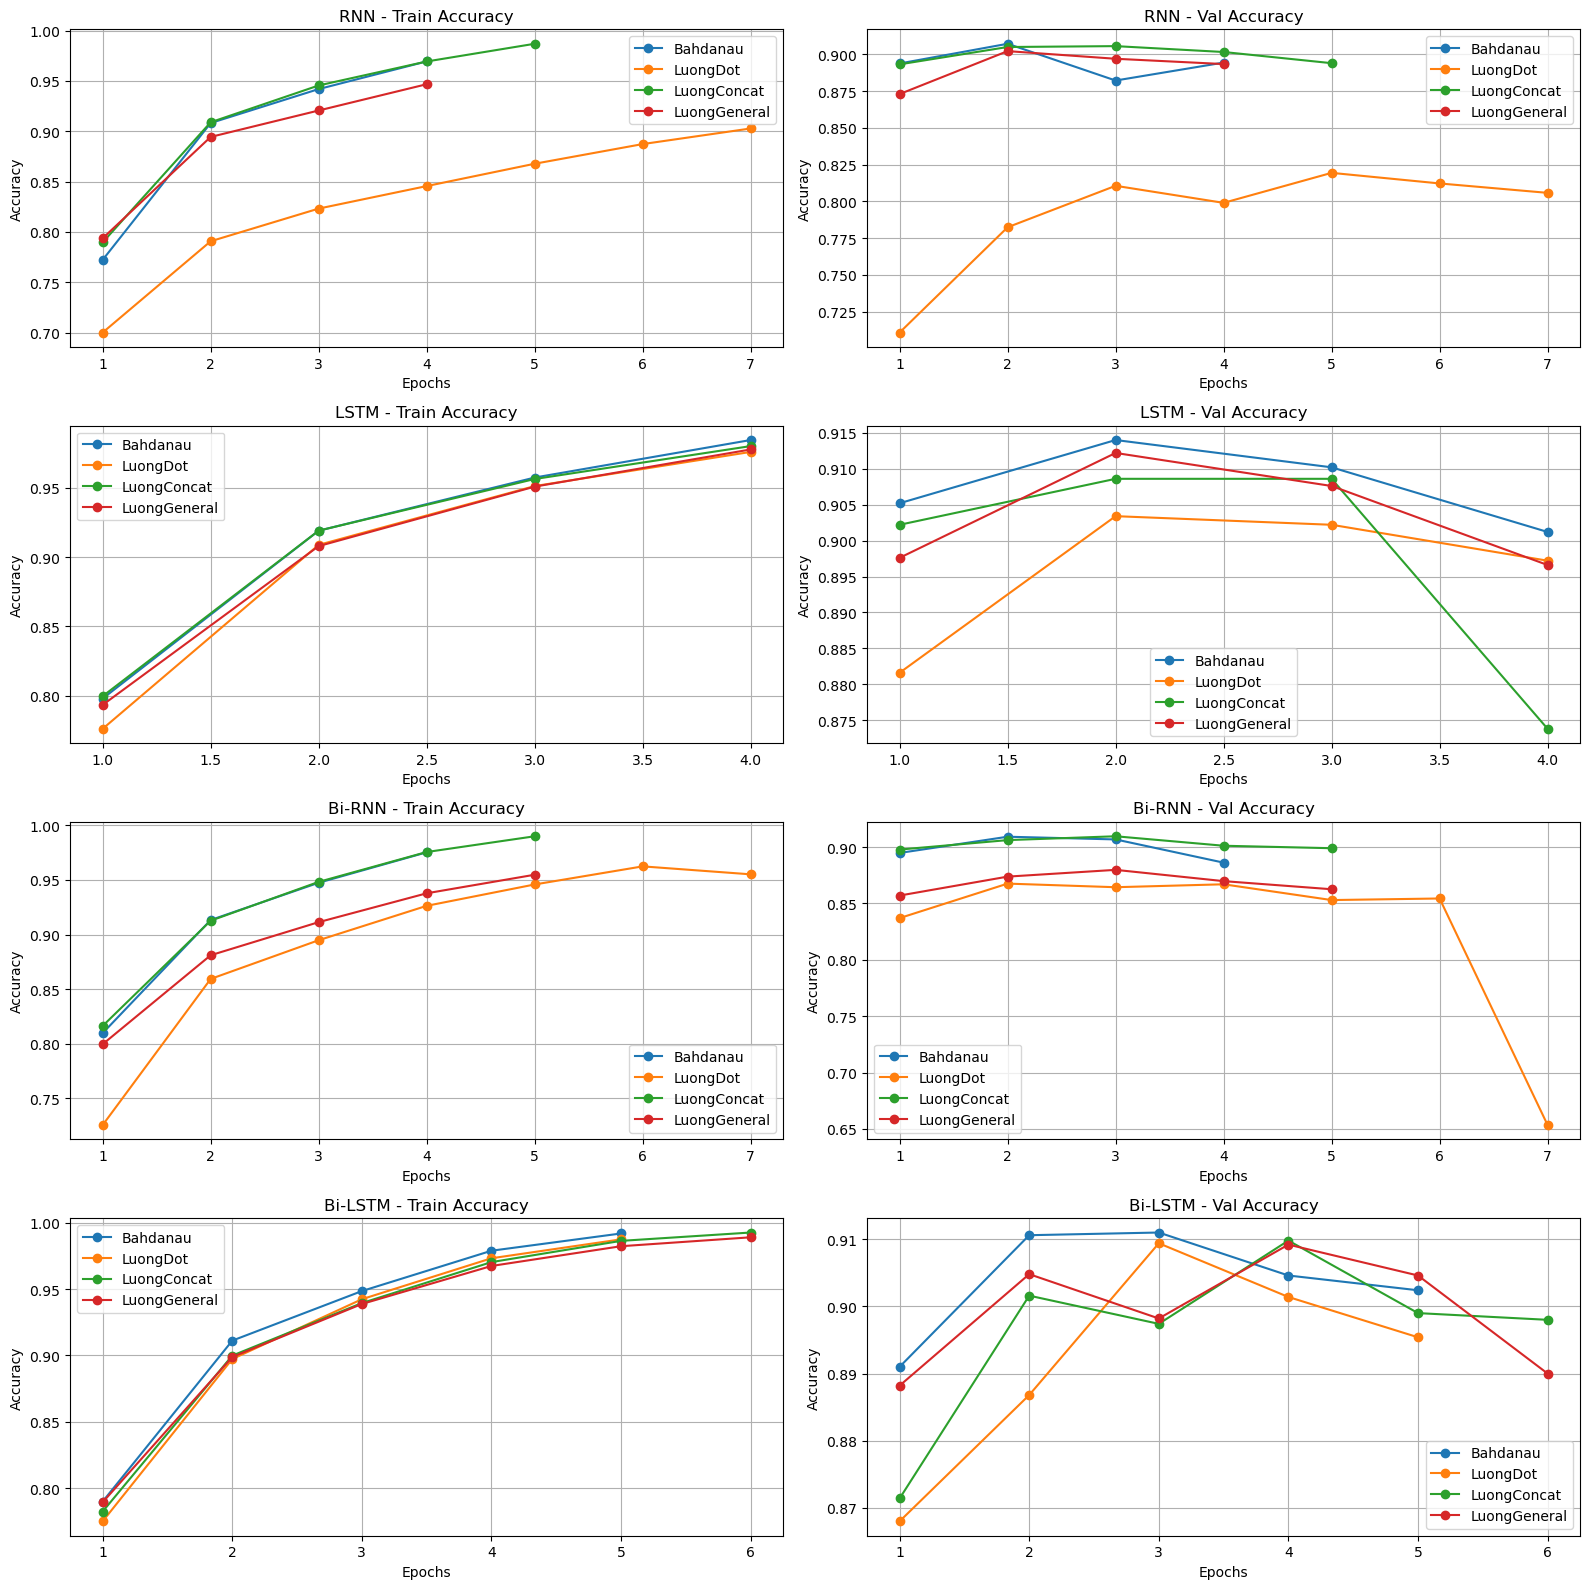

In [40]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 11)
colors = plt.get_cmap("tab10").colors  # Up to 10 colors

plt.figure(figsize=(16, 16))

# Vanilla RNN
# Train accs
plt.subplot(4, 2, 1)
for idx, (name, accs) in enumerate(rnn_train_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("RNN - Train Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Val accs
plt.subplot(4, 2, 2)
for idx, (name, accs) in enumerate(rnn_val_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("RNN - Val Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Vanilla LSTM
# Train accs
plt.subplot(4, 2, 3)
for idx, (name, accs) in enumerate(lstm_train_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("LSTM - Train Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Val accs
plt.subplot(4, 2, 4)
for idx, (name, accs) in enumerate(lstm_val_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("LSTM - Val Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Bidirectional RNN
# Train accs
plt.subplot(4, 2, 5)
for idx, (name, accs) in enumerate(birnn_train_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("Bi-RNN - Train Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Val accs
plt.subplot(4, 2, 6)
for idx, (name, accs) in enumerate(birnn_val_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("Bi-RNN - Val Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# Bidirectional LSTM
plt.subplot(4, 2, 7)
for idx, (name, accs) in enumerate(bilstm_train_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("Bi-LSTM - Train Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

plt.subplot(4, 2, 8)
for idx, (name, accs) in enumerate(bilstm_val_accs.items()):
    plt.plot(np.arange(1, len(accs) + 1), accs, marker='o', label=name, color=colors[idx % 10])
plt.title("Bi-LSTM - Val Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# --- Final Layout ---
plt.tight_layout()
plt.savefig("../plots/_baseline_models_attention_comparison.png")
plt.show()


Validation Accuracy Table:

                 RNN    LSTM   BiRNN  BiLSTM
Bahdanau      0.9072  0.9140  0.9092  0.9110
LuongDot      0.8194  0.9034  0.8676  0.9094
LuongConcat   0.9056  0.9086  0.9096  0.9098
LuongGeneral  0.9022  0.9122  0.8798  0.9092


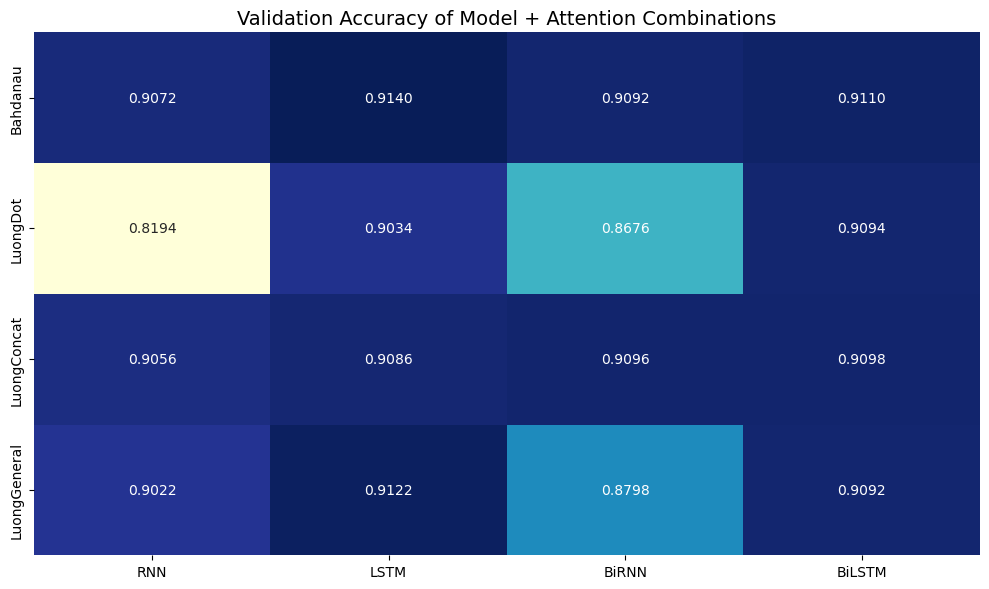


Top 4 Best Model + Attention Combinations:

1. LSTM + Bahdanau: 91.40%
2. LSTM + LuongGeneral: 91.22%
3. BiLSTM + Bahdanau: 91.10%
4. BiLSTM + LuongConcat: 90.98%


In [48]:
import pandas as pd


def max_acc_dict(d):
    return {k: max(v) for k, v in d.items()}

data = {
    "RNN": max_acc_dict(rnn_val_accs),
    "LSTM": max_acc_dict(lstm_val_accs),
    "BiRNN": max_acc_dict(birnn_val_accs),
    "BiLSTM": max_acc_dict(bilstm_val_accs)
}

# Step 2: Create and format the DataFrame
score_table = pd.DataFrame(data).round(4)
print("Validation Accuracy Table:\n")
print(score_table)

# Step 3: Identify best combo
best_attention, best_model = score_table.stack().idxmax()
best_score = score_table.loc[best_attention, best_model]
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(score_table, annot=True, fmt=".4f", cmap="YlGnBu", cbar=False)
plt.title("Validation Accuracy of Model + Attention Combinations", fontsize=14)
plt.tight_layout()
plt.savefig("../plots/model_attention_score_table.png")
plt.show()

# Step 5: Print Top 4 Best Combinations
print("\nTop 4 Best Model + Attention Combinations:\n")
top_4 = score_table.stack().sort_values(ascending=False).head(4)
for i, ((attn, model), acc) in enumerate(top_4.items(), start=1):
    print(f"{i}. {model} + {attn}: {acc * 100:.2f}%")


## Fine-tuning Hyperparameters

For optimal performance, we fine-tune the following model and attention combinations:

- **Bidirectional LSTM:**
  - Bahdanau Attention
  - Luong Concat Attention

- **Vanilla LSTM:**
  - Bahdanau Attention
  - Luong General Attention

This targeted fine-tuning allows us to systematically compare the impact of different attention mechanisms on model performance.

In [66]:
# Instantiating the listed models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Vanilla LSTM with Bahdanau Attention
lstm_1 = VanillaLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=BahdanauAttention,
    attn_dim=32,
    dropout=0.3
).to(device)


# Vanilla LSTM with Luong Concat Attention
lstm_2 = VanillaLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=LuongGeneralAttention,
    attn_dim=32,
    dropout=0.3
).to(device)


# Bidirectional LSTM with Bahdanau Attention
bilstm_1 = BidirectionalLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=BahdanauAttention,
    attn_dim=32,
    dropout = 0.3
).to(device)

# Bidirectional LSTM with Luong Concat Attention
bilstm_2 = BidirectionalLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=LuongConcatAttention,
    attn_dim=32,
    dropout = 0.3
).to(device)


/home/adishesh/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


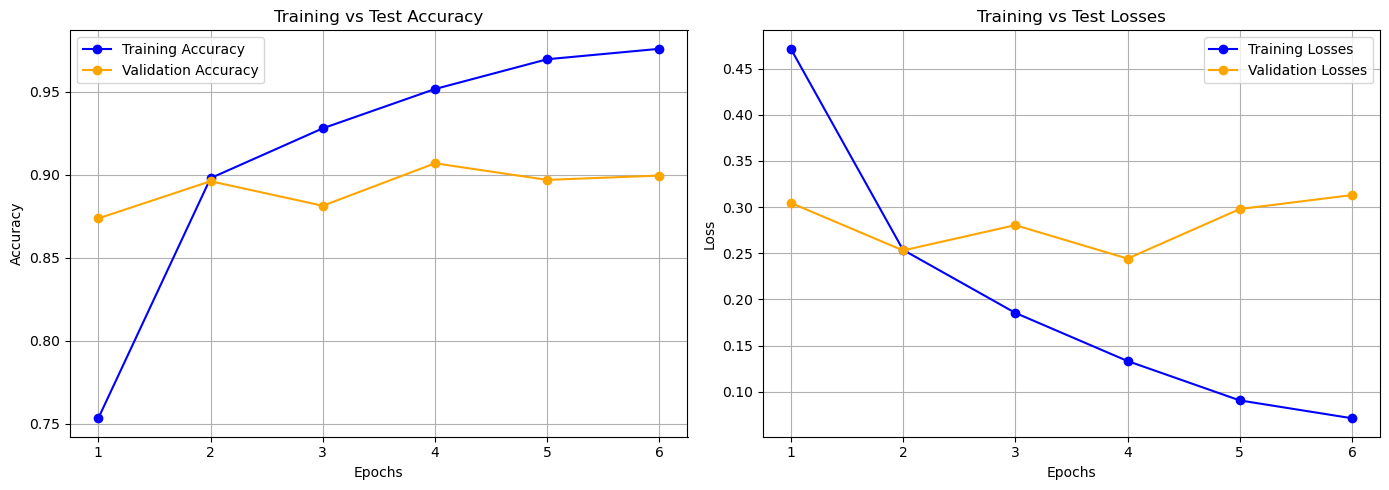

In [ ]:
# Train the first model

# Tunable Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_1.parameters(), lr=1e-3, weight_decay=5e-5)
n_epochs = 10


train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    lstm_1, train_loader, val_loader, criterion, optimizer, n_epochs, model_name="Vanilla LSTM with Bahdanau"
)
# Plot training curves for the first model
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, "Vanilla LSTM with Bahdanau", model_name="vanilla_lstm_bahdanau")

# Save the model
torch.save(lstm_1.state_dict(), "../models/vanilla_lstm_bahdanau.pth") 

Early stopping triggered at epoch 6. Best validation accuracy: 91.12% at epoch 4.


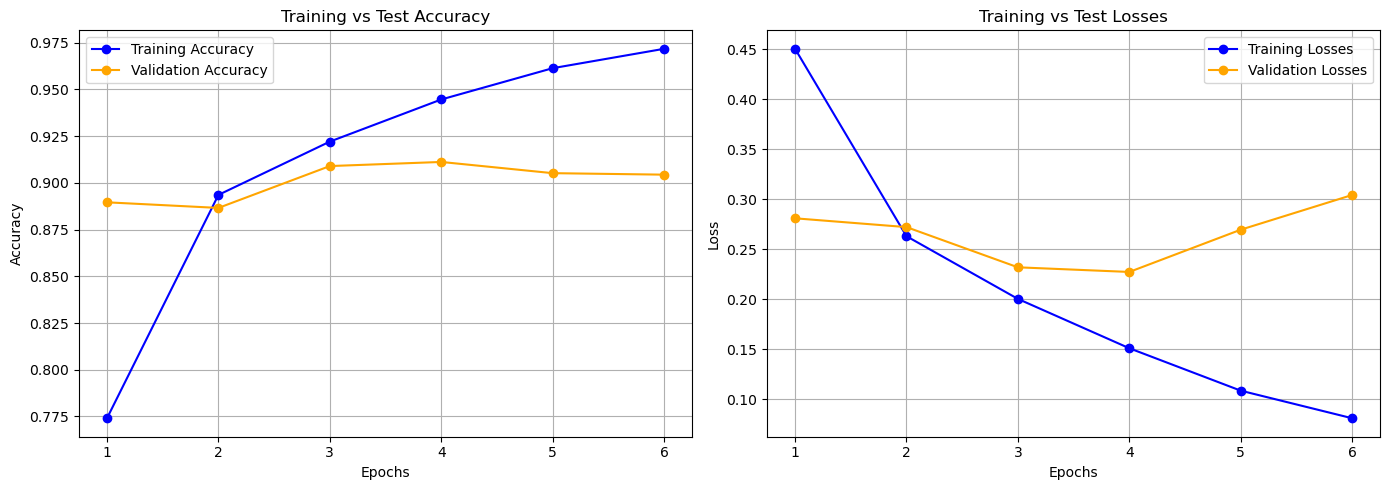

In [55]:
# Train the second model 

# Tunable Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_2.parameters(), lr=1e-3, weight_decay=5e-5)
n_epochs = 10

# Train the second model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    lstm_2, train_loader, val_loader, criterion, optimizer, n_epochs, model_name="Vanilla LSTM with Luong General"
)

# Plot training curves for the second model
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, "Vanilla LSTM with Luong General Attention", model_name="vanilla_lstm_luong_general")
torch.save(lstm_2.state_dict(), "../models/vanilla_lstm_luong_general.pth")


Early stopping triggered at epoch 5. Best validation accuracy: 90.98% at epoch 3.


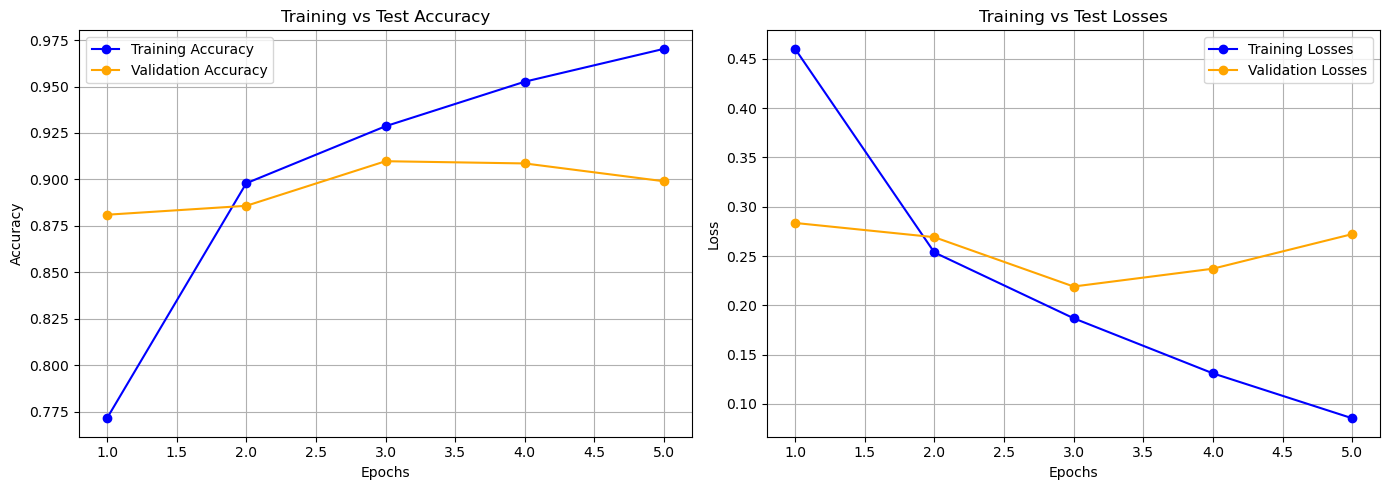

In [67]:
# Train the second model 

# Tunable Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_1.parameters(), lr=1e-3, weight_decay=5e-5)
n_epochs = 10

# Train the second model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    bilstm_1, train_loader, val_loader, criterion, optimizer, n_epochs, model_name="BiLSTM with Bahdanau"
)

# Plot training curves for the second model
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, "BiLSTM with Bahdanau", model_name="bidirectional_lstm_bahdanau")
torch.save(bilstm_1.state_dict(), "../models/bidirectional_lstm_bahdanau.pth")


Early stopping triggered at epoch 7. Best validation accuracy: 90.62% at epoch 5.


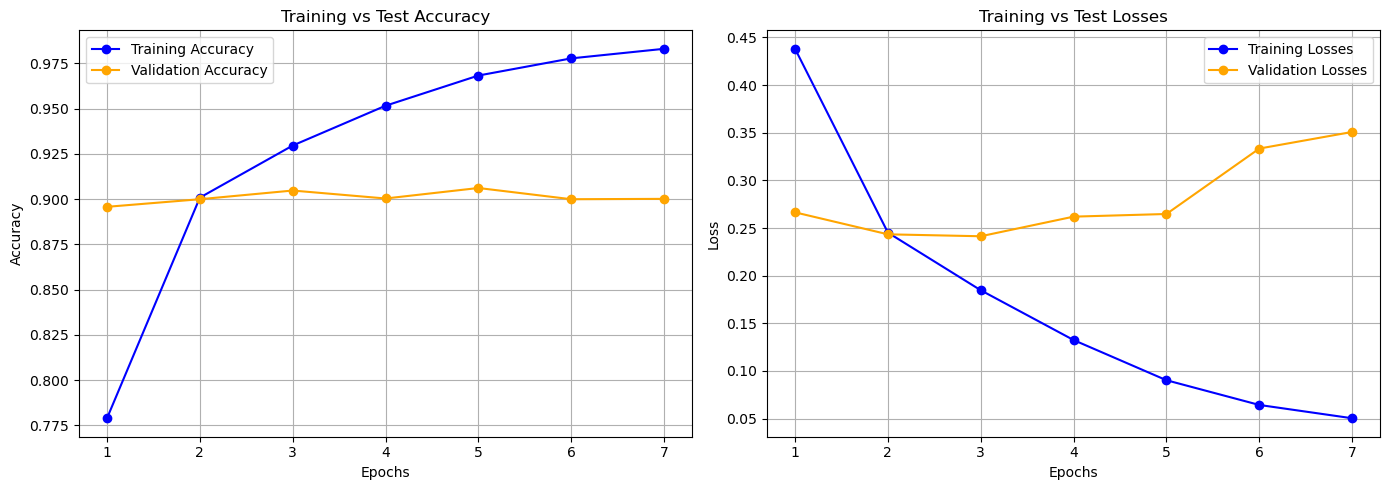

In [64]:
# Train the second model 

# Tunable Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_2.parameters(), lr=1e-3, weight_decay=5e-5)
n_epochs = 10

# Train the second model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    bilstm_2, train_loader, val_loader, criterion, optimizer, n_epochs, model_name="BiLSTM with LuongConcat"
)

# Plot training curves for the second model
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, "BiLSTM with LuongConcat", model_name="bidirectional_lstm_luong_concat")
torch.save(bilstm_2.state_dict(), "../models/bidirectional_lstm_luong_concat.pth")


In [59]:
print(device)

cuda


# Hyperparameter Tuning Results
The best performing model on the validation was surprisingly **LSTM with Luong General Attention** with
* Metrics: 
    - Train Loss: 0.0809
    - Train Accuracy: 97.17%
    - Val Loss: 0.3041
    - Val Accuracy: 90.44 %
    - Precision: 0.9047
    - Recall: 0.9044
    - F1 Score: 0.9044



In [ ]:
# Loading the best model
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            loss = criterion(output, labels)
            total_loss += loss.item()

            _, predicted = torch.max(output, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

# Evaluate the best model on the test set

# Instantiate the model architecture
best_model = VanillaLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=LuongGeneralAttention,
    attn_dim=32,
    dropout=0.3
).to(device)

# Load the saved weights
best_model.load_state_dict(torch.load("../models/vanilla_lstm_luong_general.pth"))

# Final eval
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(best_model, test_loader, criterion)

In [91]:
# Print final test metrics
# Log them in a file
with open("../logs/final_test_metrics.txt", "w") as f:
    f.write(f"Test Loss      : {test_loss:.4f}\n")
    f.write(f"Test Accuracy  : {test_accuracy*100:.2f}%\n")
    f.write(f"Test Precision : {test_precision:.4f}\n")
    f.write(f"Test Recall    : {test_recall:.4f}\n")
    f.write(f"Test F1 Score  : {test_f1:.4f}\n")
print("===== Test Set Evaluation =====")
print(f"Test Loss      : {test_loss:.4f}")
print(f"Test Accuracy  : {test_accuracy*100:.2f}%")
print(f"Test Precision : {test_precision:.4f}")
print(f"Test Recall    : {test_recall:.4f}")
print(f"Test F1 Score  : {test_f1:.4f}")

===== Test Set Evaluation =====
Test Loss      : 0.3315
Test Accuracy  : 89.85%
Test Precision : 0.8988
Test Recall    : 0.8985
Test F1 Score  : 0.8985


###  Final Test Set Evaluation Metrics

| Metric       | Value     |
|--------------|-----------|
| **Loss**     | 0.3315    |
| **Accuracy** | 89.85%    |
| **Precision**| 0.8988    |
| **Recall**   | 0.8985    |
| **F1 Score** | 0.8985    |


## Attention Plot

In [46]:
# Imports to reflect changes in attention folder to jupyter notebook
import importlib
import attention.bahdanau as bahdanau
import attention.luongdot as luongdot
import attention.luongconcat as luongconcat
import attention.luonggeneral as luonggeneral

importlib.reload(bahdanau)
importlib.reload(luongdot)
importlib.reload(luongconcat)
importlib.reload(luonggeneral)

# Importing attention mechanisms
from attention.bahdanau import BahdanauAttention
from attention.luongdot import LuongDotAttention
from attention.luongconcat import LuongConcatAttention
from attention.luonggeneral import LuongGeneralAttention



best_model = VanillaLSTM(
    embedding_matrix=embedding_matrix,
    hidden_size=64,
    output_size=2,
    attention_class=LuongGeneralAttention,
    attn_dim=32,
    dropout=0.3
).to(device)

# Load the saved weights
best_model.load_state_dict(torch.load("../models/Vanilla LSTM with Luong General.pth"))
best_model.to(device)

VanillaLSTM(
  (embedding): Embedding(83334, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (attention): LuongGeneralAttention(
    (W): Linear(in_features=64, out_features=64, bias=False)
  )
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [74]:
word2idx

{'<PAD>': 0,
 '<UNK>': 1,
 'i': 2,
 'rented': 3,
 'am': 4,
 'curiousyellow': 5,
 'from': 6,
 'my': 7,
 'video': 8,
 'store': 9,
 'because': 10,
 'of': 11,
 'all': 12,
 'the': 13,
 'controversy': 14,
 'that': 15,
 'surrounded': 16,
 'it': 17,
 'when': 18,
 'was': 19,
 'first': 20,
 'released': 21,
 'in': 22,
 '1967': 23,
 'also': 24,
 'heard': 25,
 'at': 26,
 'seized': 27,
 'by': 28,
 'us': 29,
 'customs': 30,
 'if': 31,
 'ever': 32,
 'tried': 33,
 'to': 34,
 'enter': 35,
 'this': 36,
 'country': 37,
 'therefore': 38,
 'being': 39,
 'a': 40,
 'fan': 41,
 'films': 42,
 'considered': 43,
 'controversial': 44,
 'really': 45,
 'had': 46,
 'see': 47,
 'for': 48,
 'myselfthe': 49,
 'plot': 50,
 'is': 51,
 'centered': 52,
 'around': 53,
 'young': 54,
 'swedish': 55,
 'drama': 56,
 'student': 57,
 'named': 58,
 'lena': 59,
 'who': 60,
 'wants': 61,
 'learn': 62,
 'everything': 63,
 'she': 64,
 'can': 65,
 'about': 66,
 'life': 67,
 'particular': 68,
 'focus': 69,
 'her': 70,
 'attentions': 71,


In [66]:
def encode_text(text, word2idx):
    return [word2idx.get(word, word2idx["<UNK>"]) for word in text.split()]

def pad_sequence_to_length(seq, max_len, pad_idx):
    return seq + [pad_idx] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]


In [67]:
def get_attention_weights(text, model, word2idx, max_len=50):
    model.eval()
    with torch.no_grad():
        tokens = encode_text(text, word2idx)
        padded_tokens = pad_sequence_to_length(tokens, max_len, pad_idx=word2idx["<PAD>"])
        input_tensor = torch.tensor([padded_tokens], dtype=torch.long).to(device)

        output = model(input_tensor)

        if isinstance(output, tuple):  # has attention
            logits, attn_weights = output
            attn_weights = attn_weights.cpu().numpy()[0]
        else:
            logits = output
            attn_weights = np.zeros(len(padded_tokens))  # dummy, if no attention used

        predicted_label = torch.argmax(torch.softmax(logits, dim=1), dim=1).item()
        return attn_weights, padded_tokens, predicted_label


In [68]:
def get_attention_weights(text, model, word2idx, max_len=50):
    model.eval()
    with torch.no_grad():
        tokens = encode_text(text, word2idx)
        padded_tokens = pad_sequence_to_length(tokens, max_len, pad_idx=word2idx["<PAD>"])
        input_tensor = torch.tensor([padded_tokens], dtype=torch.long).to(device)

        output = model(input_tensor)

        if isinstance(output, tuple):  # has attention
            logits, attn_weights = output
            attn_weights = attn_weights.cpu().numpy()[0]
        else:
            logits = output
            attn_weights = np.zeros(len(padded_tokens))  # dummy, if no attention used

        predicted_label = torch.argmax(torch.softmax(logits, dim=1), dim=1).item()
        return attn_weights, padded_tokens, predicted_label


In [78]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(token_ids, attn_weights, word2idx):
    idx2word = {idx: word for word, idx in word2idx.items()}
    tokens = [idx2word.get(idx, "<UNK>") for idx in token_ids]

    # Trim padding
    trimmed_tokens = []
    trimmed_weights = []
    for tok, wt in zip(tokens, attn_weights):
        if tok == "<PAD>":
            break
        trimmed_tokens.append(tok)
        trimmed_weights.append(wt)

    fig, ax = plt.subplots(figsize=(12, 2))
    ax.bar(range(len(trimmed_weights)), trimmed_weights, tick_label=trimmed_tokens, color='skyblue')
    ax.set_xticks(range(len(trimmed_tokens)))
    ax.set_xticklabels(trimmed_tokens, rotation=45, ha='right')
    ax.set_ylabel("Attention Weight")
    ax.set_title("Attention over Tokens")
    plt.tight_layout()
    plt.savefig("../plots/attention_weights.png")
    plt.show()


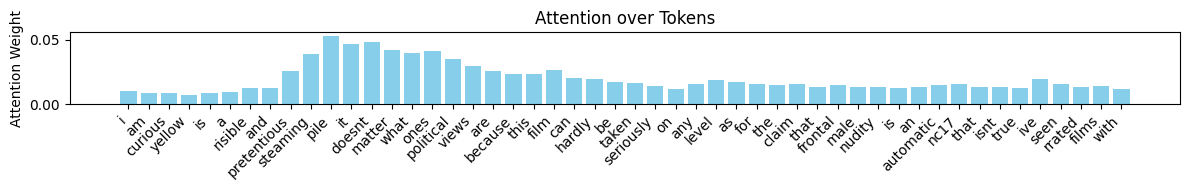

Predicted Label: 0


In [79]:
sample_text = train_df["text"].iloc[1]
attn_weights, token_ids, pred_label = get_attention_weights(sample_text, best_model, word2idx)
visualize_attention(token_ids, attn_weights, word2idx)

print(f"Predicted Label: {pred_label}")
